This notebook goes over how to plot the GHI output from single OptWRF model realizations for both WRF and ERA5

Last Updated Oct 7, 2020

In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf
from optwrf import runwrf

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [2]:
# Verbose setting
verbose = True

# Define the datestr and paramstr
datestr = '2011-12-13'
paramstr = '19mp4lw4sw7lsm8pbl99cu'
wrffile_name = f'wrfout_processed_d01_{datestr}_{paramstr}.nc'
wrffile_name_orig = f'wrfout_d01_{datestr}_{paramstr}.nc'

# Find the absolute file path to your optwrf package
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))
optwrf_abspath

# Open the original wrfout data (to use wrf-python I need the format from here)
wrffile_orig = os.path.join(optwrf_abspath, 'data', wrffile_name_orig)
wrfdata_orig = netCDF4.Dataset(wrffile_orig)
if verbose:
    print(f'Original WRF DATA:\n{wrfdata_orig}\n')

# Open the processed wrfout data
wrffile = os.path.join(optwrf_abspath, 'data', wrffile_name)
wrfdata = xr.open_dataset(wrffile)
if verbose:
    print(f'Processeed WRF DATA:\n{wrfdata}\n')
    
# Open the processed ERA5 data
erafile = os.path.join(optwrf_abspath, 'data', 'ERA5_EastUS_WPD-GHI_2011-12.nc')
eradata = xr.open_dataset(erafile)
if verbose:
    print(f'ERA5 DATA:\n{eradata}')

Original WRF DATA:
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    TITLE:  OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE: 2011-12-13_00:00:00
    SIMULATION_START_DATE: 2011-12-13_00:00:00
    WEST-EAST_GRID_DIMENSION: 192
    SOUTH-NORTH_GRID_DIMENSION: 192
    BOTTOM-TOP_GRID_DIMENSION: 36
    DX: 12000.0
    DY: 12000.0
    AERCU_OPT: 0
    AERCU_FCT: 1.0
    IDEAL_CASE: 0
    DIFF_6TH_SLOPEOPT: 0
    AUTO_LEVELS_OPT: 2
    DIFF_6TH_THRESH: 0.1
    DZBOT: 50.0
    DZSTRETCH_S: 1.3
    DZSTRETCH_U: 1.1
    SKEBS_ON: 0
    SPEC_BDY_FINAL_MU: 1
    USE_Q_DIABATIC: 0
    GRIDTYPE: C
    DIFF_OPT: 1
    KM_OPT: 4
    DAMP_OPT: 0
    DAMPCOEF: 0.2
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 19
    RA_LW_PHYSICS: 4
    RA_SW_PHYSICS: 4
    SF_SFCLAY_PHYSICS: 1
    SF_SURFACE_PHYSICS: 7
    BL_PBL_PHYSICS: 8
    CU_PHYSICS: 99
    SF_LAKE_PHYSICS: 0
    SURFACE_INPUT_SOURCE: 1
    SST_UPDATE: 0
    GRID_FDDA: 0
    GFDDA_INTERVAL_M: 

In [7]:
dni_orig = getvar(wrfdata_orig, "SWDDNI", timeidx=15)
# Get the cartopy mapping object
wrf_cartopy_proj = get_cartopy(dni_orig)
# Get the latitude and longitude points
lats, lons = latlon_coords(dni_orig)

In [17]:
cartopy_ylim(dni_orig)

[-1030733.7709325083, 1249265.7240848024]

Text(0.5, 1.0, 'title_str')

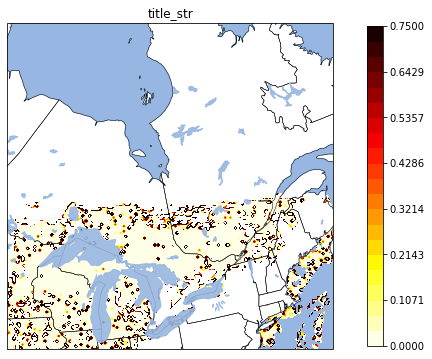

In [18]:
# Create a figure
fig = plt.figure(figsize=(12,6))

# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=wrf_cartopy_proj)

# Set the map bounds
ax.set_xlim(cartopy_xlim(dni_orig))
ax.set_ylim(cartopy_xlim(dni_orig))

# Download and add the states, coastlines, and lakes
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
#     ax.coastlines(resolution='10m', linewidth=0.8)
ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

# Make the countour lines for filled contours for the GHI
contour_levels = np.linspace(0, 0.75, 22)
plt.contourf(to_np(lons), to_np(lats), to_np(dni_orig), 
                  contour_levels,
                  transform=ccrs.PlateCarree(),
                  cmap=get_cmap("hot_r"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Add the gridlines
#     ax.gridlines(color="black", linestyle="dotted")

# Add the axis title
plt.title("title_str")